In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.base import clone
from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
reviews = pd.read_csv('/kaggle/input/threads-an-instagram-app-reviews/threads_reviews.csv')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              32910 non-null  object
 1   review_description  32910 non-null  object
 2   rating              32910 non-null  int64 
 3   review_date         32910 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [3]:
#A function for converting polarity values into categorical features.
def get_sentiment(text):
    if TextBlob(text).sentiment.polarity < 0:
        return 'Negative'
    elif TextBlob(text).sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Positive'

reviews['sentiment'] = reviews['review_description'].apply(lambda x: get_sentiment(x))

reviews['sentiment'].head(5)

0    Positive
1    Positive
2    Positive
3    Positive
4    Positive
Name: sentiment, dtype: object

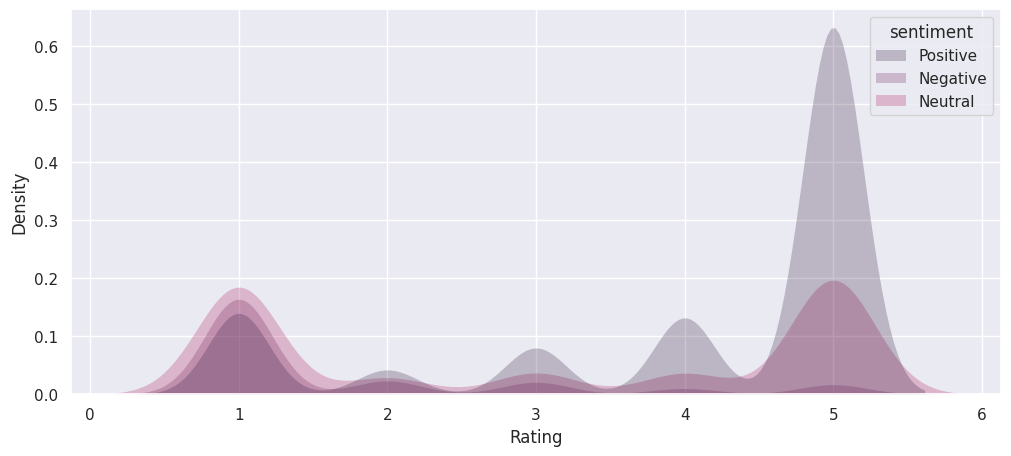

In [4]:
sns.set_theme(style = 'darkgrid', palette = 'rocket')
plt.figure(figsize = (12,5))
sns.kdeplot(data = reviews, x = 'rating', hue = 'sentiment', fill = True, linewidth = 0)
plt.xlabel('Rating')
plt.show()

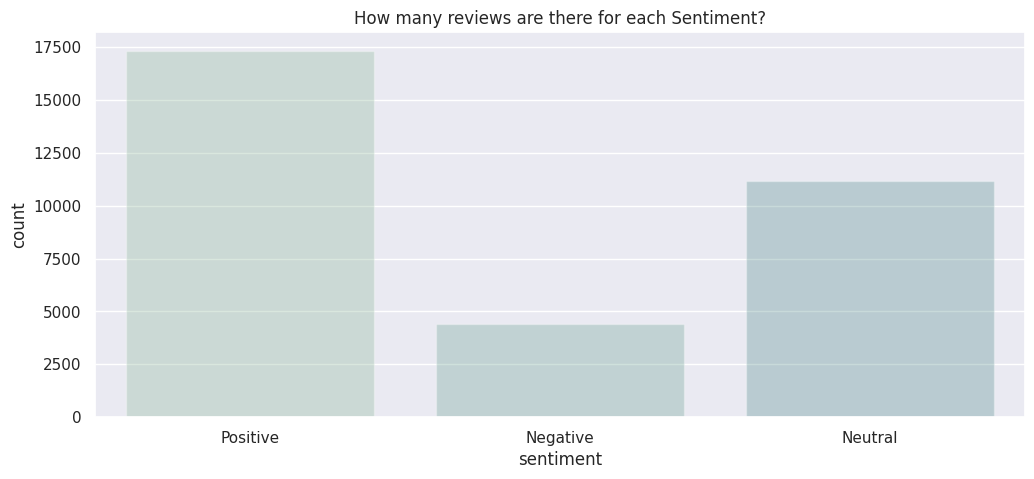

In [5]:
sns.set_theme(style = 'darkgrid', palette = 'crest')
plt.figure(figsize = (12,5))
plt.title('How many reviews are there for each Sentiment?')
sns.countplot(data = reviews, x = 'sentiment', alpha = 0.3)
plt.show()

(-0.5, 999.5, 599.5, -0.5)

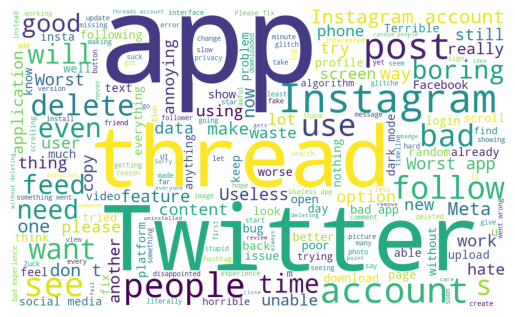

In [6]:
all_text = ' '.join(reviews['review_description'].loc[reviews['sentiment'] == 'Negative'])
word_cloud = WordCloud(width=1000, height=600, background_color='white').generate(all_text)
sns.set_theme(style = 'white', palette = 'pastel')
plt.imshow(word_cloud)
plt.axis('off')

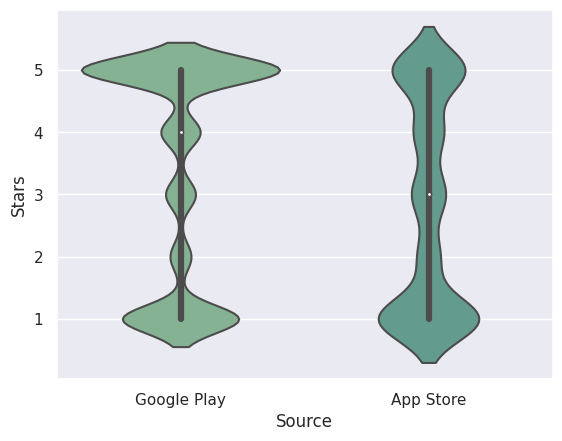

In [7]:
sns.set_theme(style = 'darkgrid', palette = 'crest')
sns.violinplot(data = reviews, x = 'source', y = 'rating', alpha = 0.3)
plt.xlabel('Source')
plt.ylabel('Stars')
plt.show()

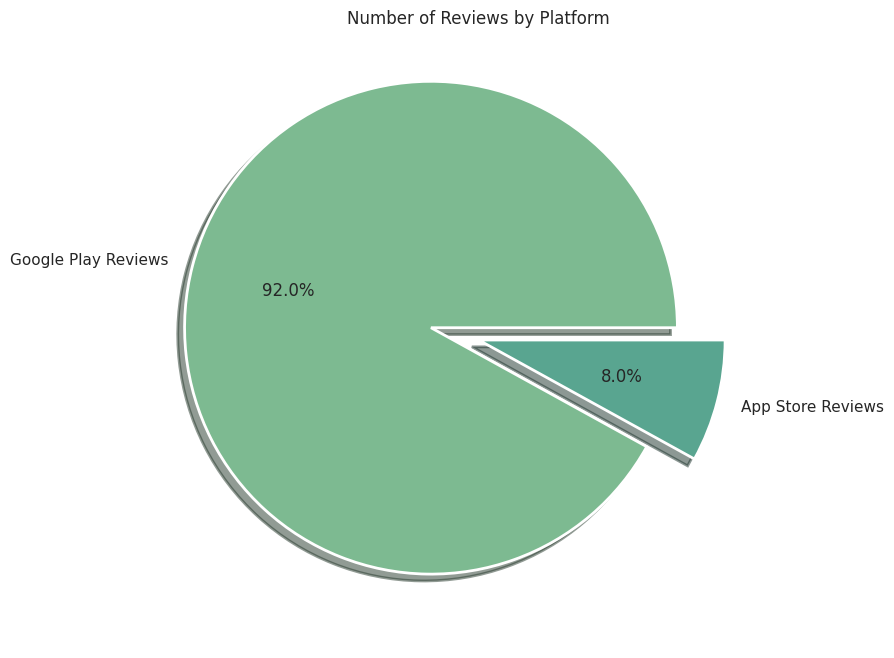

In [8]:
sns.set_theme(palette = 'crest')
plt.figure(figsize=(8,8))
plt.pie(x = [len(reviews[reviews['source'] == 'Google Play']), len(reviews[reviews['source'] == 'App Store'])],
         shadow = True, wedgeprops = {'linewidth': 2, 'edgecolor': 'white'}, explode = [0.2, 0.0], 
         labels = ['Google Play Reviews', 'App Store Reviews'], autopct = '%1.1f%%')
plt.title('Number of Reviews by Platform')
plt.show()

In [9]:
#Let's create a copy of the dataset, so we can freely play with the dataset.
reviews_copy = reviews.copy()
reviews_copy = reviews_copy.drop(['review_date', 'source'], axis = 1)

In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
text = 'A'
#preprocessing phase
def preprocessing_text(df = reviews_copy):
    
    #Lowering the text
    df['lowered'] = df['review_description'].apply(lambda x: x.lower())
    
    #Tokenization
    df['tokens'] = df['lowered'].apply(lambda x: nlp(x))
    
    #Removing punctuation.
    df['no_punct'] = df['tokens'].apply(lambda x: [word for word in x if word.is_punct == False])
    
    #Removing stopwords.
    #df['no_stops'] = df['no_punct'].apply(lambda x: [word for word in x if word.is_stop == False])
    
    """
    In some cases you may want to remove stop words, but in this case stop words may help the model to
    predict better. (For example, 'not' is a stop words and also contains negativity. If we remove 'not'
    the sentiment polarity may increase and we loss some 'negativity'. In case, if you want to remove
    stop words, just remove '#' symbol above.
    
    """
    #Lemmatization.
    df['lemmatized'] = df['no_punct'].apply(lambda x: [word.lemma_ for word in x])
    
    #Joining together.
    df['review_filtered'] = df['lemmatized'].apply(lambda x: ' '.join(x))
    
    return df['review_filtered']

In [12]:
reviews['preprocessed'] = preprocessing_text(df = reviews_copy)
reviews['preprocessed'].head(10)

0    meh not the great experience on a chromebook s...
1    pretty good for a first launch its easy to use...
2    for a brand new app it be very well optimize h...
3    great app with a lot of potential however ther...
4    the app be good but it need a lot of functiona...
5    currently it be very challenging to use it be ...
6    I still do not want to see content from people...
7    could be great if all page load when you click...
8    I be like the concept there be room for improv...
9    not bad this be its first launch there be stil...
Name: preprocessed, dtype: object

In [13]:
smote = SMOTE(random_state = 1000, sampling_strategy = 'minority')
encoder = LabelEncoder() #for encoding the label
vectorizer = TfidfVectorizer() #for more info. about TF-IDF, https://www.youtube.com/watch?v=ATK6fm3cYfI
X = reviews['preprocessed']
y = encoder.fit_transform(reviews['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1000)
mnb = Pipeline([('vectorizer', vectorizer), ('over_sampling', smote), ('model', MultinomialNB())])
gb = Pipeline([('vectorizer', vectorizer), ('over_sampling', smote), ('model', GradientBoostingClassifier())])

#Note: We are using imblearn.pipeline.Pipeline not sklearn.pipeline.Pipeline you'll get an error if you use SMOTE with sklearn.pipeline.Pipeline

In [14]:
models = {
    'MultinomialNB': mnb,
    'GradientBoostingClassifier': gb
}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of {}: '.format(name), accuracy_score(y_test, y_pred))

Accuracy of MultinomialNB:  0.6715284108173807
Accuracy of GradientBoostingClassifier:  0.8274080826496506


In [15]:
synthetic_reviews = ['This is the worst thing I have ever seen. This App makes me wanna puke.',
                    "Optimization is very good in this App, even better than Twitter. Congratilations, Meta!",
                    "Come on Mark! Could you stop mimicking Elon?? I hate you."]
y_synthetic = gb.predict(synthetic_reviews)

In [16]:
y_synthetic = encoder.inverse_transform(y_synthetic)
y_synthetic

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [17]:
print(encoder.inverse_transform(np.unique(y_pred)), ' | ', np.unique(y_pred))
#With help of encoder.inverse_transform you can inverse transform the labels into 'words' again.

['Negative' 'Neutral' 'Positive']  |  [0 1 2]


<Axes: >

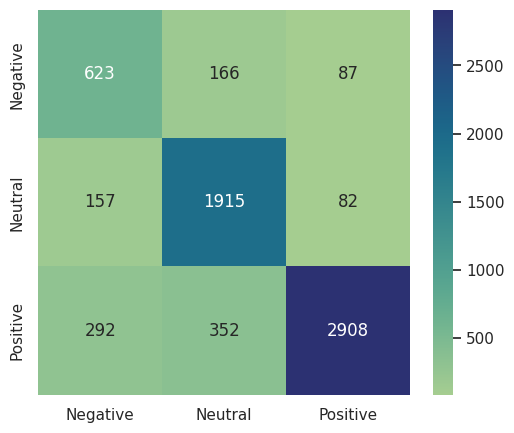

In [18]:
classes = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize = (6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), fmt = 'd', annot = True, cmap = 'crest', xticklabels = classes, yticklabels = classes)